# Create dataset for Caffe

reference: [Creating an LMDB database in Python](http://deepdish.io/2015/04/28/creating-lmdb-in-python/)

## Parameters
configure parameters in [caffe_ball_param.py](./caffe_ball_param.py)

## Setup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os
from os import listdir
from os.path import isfile, join, splitext
import cPickle as pickle

import numpy as np
import cv2
import lmdb


caffe_root = os.environ.get('CAFFE_ROOT', None)
if not caffe_root:
    raise "Please set CAFFE ROOT!"

sys.path.insert(0, os.path.join(caffe_root, 'python'))
import caffe

from ml_utils import load_images, create_image_wall

plt.rcParams['figure.figsize'] = (15, 50)
plt.rcParams['image.interpolation'] = 'nearest'

from caffe_ball_param import *

if GRAY:
    N_CHANNEL = 1
    plt.rcParams['image.cmap'] = 'gray'
else:
    N_CHANNEL = 3


ball_files_and_labels = [[n, 1] for n in ball_files]
noball_files_and_labels = [[n, 0] for n in noball_files]

files_and_target = np.vstack((ball_files_and_labels, noball_files_and_labels))
permutation = np.random.permutation(len(files_and_target))
n_training_data = int(len(files_and_target) * 0.7)

## Training dataset

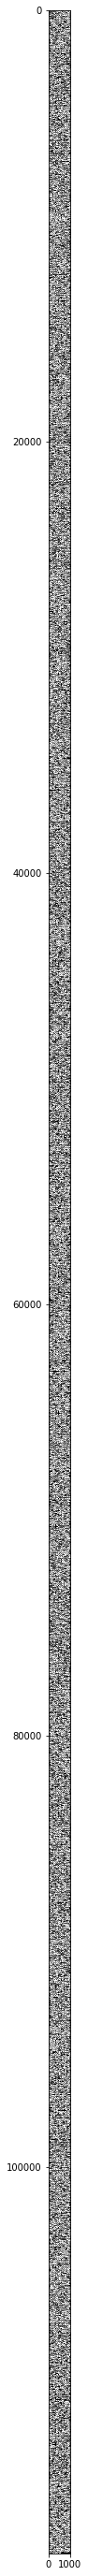

In [5]:
traning_files_and_target = files_and_target[permutation[:n_training_data]]
np.savetxt('ball_train_dataset.txt', traning_files_and_target, "%s")

files = traning_files_and_target[:, 0]
targets = traning_files_and_target[:, 1]

traning_data_and_target = load_images(files, targets, sample_shape, GRAY)
data = traning_data_and_target[:, :-1].reshape(-1, sample_shape[0], sample_shape[1], N_CHANNEL)

targets = traning_data_and_target[:, -1]

# show part of the data
plt.imshow(create_image_wall(data[::10], sample_shape, mask=targets[::10]))

## Testing dataset

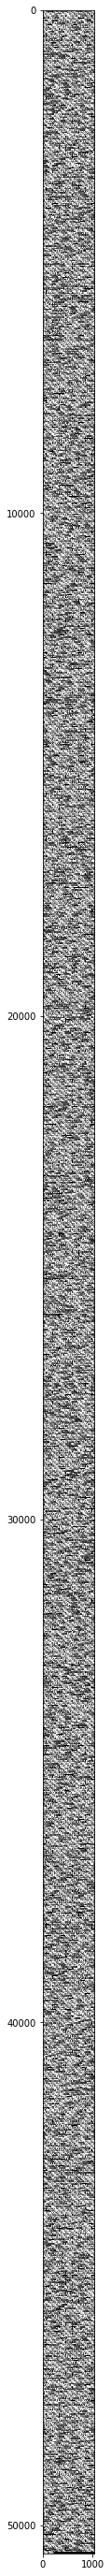

In [6]:
test_files_and_target = files_and_target[permutation[n_training_data:]]
np.savetxt('ball_test_dataset.txt', test_files_and_target, "%s")

test_files = test_files_and_target[:, 0]
test_targets = test_files_and_target[:, 1]

test_data_and_target = load_images(test_files, test_targets, sample_shape, GRAY)
test_data = test_data_and_target[:, :-1].reshape(-1, sample_shape[0], sample_shape[1], N_CHANNEL)
test_targets = test_data_and_target[:, -1]

# show part of the data
plt.imshow(create_image_wall(test_data[::10], sample_shape, mask=test_targets[::10]))

## save data in database and compute mean

In [7]:
def reshape_data_for_caffe(data):
    data = data.reshape(-1, sample_shape[0], sample_shape[1], N_CHANNEL)
    if not GRAY:
        y_data = data[:, :, :, 0].reshape(-1, sample_shape[0] * sample_shape[1])
        u_data = data[:, :, :, 1].reshape(-1, sample_shape[0] * sample_shape[1])
        v_data = data[:, :, :, 2].reshape(-1, sample_shape[0] * sample_shape[1])

        X = np.hstack((y_data, u_data, v_data)).reshape(-1, 3, sample_shape[0], sample_shape[1])
    else:
        X = data.reshape(-1, 1, sample_shape[0], sample_shape[1])
    return X

In [8]:
def save_data(data, labels, lmdb_name):
    X = reshape_data_for_caffe(data)
    map_size = X.nbytes * 10
    env = lmdb.open(lmdb_name, map_size=map_size)

    with env.begin(write=True) as txn:
        # txn is a Transaction object
        for i in range(len(X)):
            datum = caffe.proto.caffe_pb2.Datum()
            datum.channels = X.shape[1]
            datum.height = X.shape[2]
            datum.width = X.shape[3]
            datum.data = X[i].tobytes()  # or .tostring() if numpy < 1.9
            datum.label = int(labels[i])
            str_id = '{:08}'.format(i)

            # The encode is only essential in Python 3
            txn.put(str_id.encode('ascii'), datum.SerializeToString())

In [9]:
!rm -rf ball_train_lmdb ball_test_lmdb

In [10]:
save_data(data, targets, "ball_train_lmdb")
save_data(test_data, test_targets, "ball_test_lmdb")

In [11]:
with open("ball_train.pkl", 'w') as f:
    pickle.dump((data, targets), f, protocol=pickle.HIGHEST_PROTOCOL)
with open("ball_test.pkl", 'w') as f:
    pickle.dump((test_data, test_targets), f, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
!bash compute_mean.sh

bash: compute_mean.sh: Datei oder Verzeichnis nicht gefunden


## (optional) Inspect Database

In [14]:
lmdb_name = "ball_train_lmdb"
env = lmdb.open(lmdb_name)

with env.begin() as txn:
    raw_datum = txn.get(b'00000035')  # get nr. 35 in database

datum = caffe.proto.caffe_pb2.Datum()
datum.ParseFromString(raw_datum)

flat_x = np.fromstring(datum.data, dtype=np.uint8)
x = flat_x.reshape(datum.channels, datum.height, datum.width)
y = datum.label

label 0


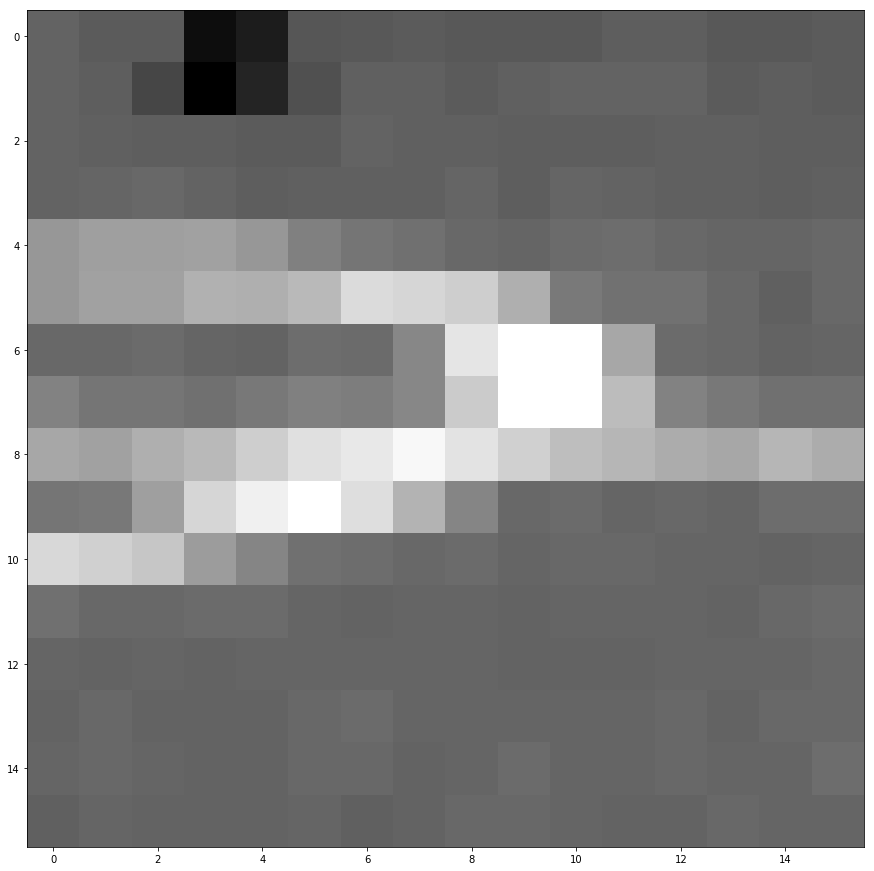

In [15]:
if not GRAY:
    img = x.reshape(3, -1)
    img = img.T
    img = img.reshape(x.shape[1], x.shape[2], x.shape[0]) / 255
else:
    img = np.array(x)
    img = img.reshape(x.shape[1], x.shape[2])
plt.imshow(img)
print 'label', y